In [20]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [21]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [22]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [23]:
%matplotlib inline

# Data

In [27]:
# Read data
path = '../../../fail.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(56, 57), dtype=bool)

In [28]:
motion.shape

(3, 58)

In [29]:
motion[:50, 1]

array([0., 0., 0.])

In [30]:
contacts.shape

(3, 2)

In [31]:
contacts[0:5]

array([[False, False],
       [ True, False],
       [False, False]])

In [39]:
motion[0]

array([ 8.99999976e-01,  0.00000000e+00,  0.00000000e+00,  3.00000000e-01,
        1.20116457e-01, -3.69025916e-01,  1.27121925e-01, -1.15985245e-01,
       -3.68312925e-01, -3.68310034e-01,  1.36808977e-01, -3.84327859e-01,
       -1.86425865e-01, -1.38723642e-01, -3.67282897e-01,  3.28761625e+00,
       -3.59021932e-01, -3.71536046e-01,  4.56075788e-01, -1.39705874e-02,
        1.09994514e-02, -6.34828731e-02, -4.15827453e-01,  2.02307850e-03,
        4.19791229e-02, -3.34893644e-01,  1.78914964e-02,  1.08095817e-01,
       -3.54542315e-01,  4.67999876e-02, -1.37998313e-01, -5.66417158e-01,
       -1.59553711e-05, -6.34642737e-03,  6.90000000e+01,  1.40000000e+02,
        4.20000000e+01,  2.80000000e+01,  8.51837266e-03,  1.38584466e-03,
       -1.57209858e-01,  9.87527490e-01,  1.63894910e-02,  5.41549036e-03,
       -3.15696985e-01,  3.87229396e-02, -5.70368303e-03, -9.11614759e-03,
        1.16323941e-03,  1.00366946e-01,  5.67065352e-02,  9.77029270e+00,
       -1.49333334e+00, -

## Height-Force plots

In [32]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [33]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

# Dataset Preparation

In [34]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [35]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [36]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [44]:
def create_acceleration_com_dataset(dataset, footsteps, motion=None, debug=False):
    idx = 1
    inputs = []
    labels = []
    prev_com_velocity = np.asarray([0, 0, 0])
    
    while idx < len(footsteps):
        if idx > 0:
            # Compute time difference footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            # Round velocity array
            dataset[footsteps[idx-2], 1:4] = np.around(dataset[footsteps[idx-2], 1:4], decimals=1)
            dataset[footsteps[idx-1], 1:4] = np.around(dataset[footsteps[idx-1], 1:4], decimals=1)
            
            # Skip if data switch
            if dataset[footsteps[idx], -1] != dataset[footsteps[idx-1], -1]:
                idx += 2
                continue
            
            # Continuous data
            if dataset[footsteps[idx], -1] == 0:
                # If accelerating from 0.0 skip the first two steps
                if dataset[footsteps[idx-2], 1] == 0.0:
                    idx += 2
                    continue
                
                # If actual velocity is 0.0 skip
                if dataset[footsteps[idx-1], 1] == 0.0:
                    idx += 1
                    continue
                    
                # If different velocities (non-zero) skip
                if dataset[footsteps[idx-2], 1] != dataset[footsteps[idx-1], 1]:
                    idx += 3
                    continue
            
            if time_difference < 0.4:
                fl_rr_moving = contacts[footsteps[idx], 0]
                fr_rl_moving = contacts[footsteps[idx], 1]
                print(idx, fl_rr_moving, fr_rl_moving)
                
                if fl_rr_moving == fr_rl_moving:
                    print("Invalid")
                    
                    
                # Compute rotation matrix incurred
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 39:43])

                # Retrieve base poses in world frame
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]
                
                # Compute world displacement
                world_displacement = curr_base - prev_base
                
                # Compute base displacement
                base_displacement = np.dot(R_curr.T, world_displacement)
                
                # Compute yaw displacement
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 39:43])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 39:43])
                yaw = curr_yaw - prev_yaw
                
                # Compute velocity
                current_com_velocity = base_displacement/time_difference
                
                # Handle angle wrap
                #if np.sign(prev_yaw) != np.sign(curr_yaw):
                #    #print("Angle wrap detected.")
                #    continue
                
                inputs.append(dataset[footsteps[idx-2], 1:4].tolist() + # previous cmd
                              dataset[footsteps[idx-1], 1:4].tolist() + # current cmd
                              dataset[footsteps[idx-1], 19:23].tolist() + # current velocity
                              dataset[footsteps[idx-1], 4:16].tolist() + # feet position w.r.t CoM
                              dataset[footsteps[idx-2], 19:23].tolist() + # previous velocity
                              current_com_velocity.tolist() +
                              [fl_rr_moving, fr_rl_moving]) # swiging booleans
                
                # Labels
                labels.append([base_displacement[0], base_displacement[1], yaw])
                
                prev_com_velocity = current_com_velocity
        
        idx += 1
                
    return np.array(inputs, dtype=object), np.array(labels, dtype=object)

# Stack datasets
X_motion_CoM_acceleration, Y_motion_CoM_acceleration = create_acceleration_com_dataset(motion, [x for x in range(len(motion))])
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

1 True False
2 False False
Invalid
(2, 31)
(2, 3)


/tmp/ipykernel_108804/2773007759.py:66: RuntimeWarning: divide by zero encountered in divide
  current_com_velocity = base_displacement/time_difference


In [18]:
%store X_motion_CoM_acceleration
%store Y_motion_CoM_acceleration

Stored 'X_motion_CoM_acceleration' (ndarray)
Stored 'Y_motion_CoM_acceleration' (ndarray)


In [41]:
min(Y_motion_CoM_acceleration[:, 0])

0.042698485578608246

In [43]:
X_motion_CoM_acceleration[1]

array([0.0, 0.0, 0.3, 0.0, 0.0, 0.2, 0.01493687555193901,
       -0.08053922653198242, 0.03132565692067146, -0.5486275553703308,
       0.12446818500757217, -0.3669784665107727, 0.3314911723136902,
       -0.1373138427734375, -0.3595713675022125, -0.16923360526561737,
       0.11966679990291595, -0.36875125765800476, -0.3376825153827667,
       -0.12701818346977234, -0.3662409484386444, 3.426081657409668,
       -0.013970587402582169, 0.010999451391398907, -0.0634828731417656,
       -0.4158274531364441, inf, -inf, inf, False, False], dtype=object)

In [19]:
dic = dict()
for x in range(len(X_motion_CoM_acceleration)):
    key = str(round(X_motion_CoM_acceleration[x, 0], 1)) + str(round(X_motion_CoM_acceleration[x, 3], 1))
    if key in dic:
        dic[key][0].append(Y_motion_CoM_acceleration[x, 0])
        dic[key][1].append(X_motion_CoM_acceleration[x, -5])
        dic[key][2].append(X_motion_CoM_acceleration[x, 6])
    else:
        dic[key] = [[Y_motion_CoM_acceleration[x, 0]], 
                    [X_motion_CoM_acceleration[x, -5]],
                    [X_motion_CoM_acceleration[x, 6]]]

In [19]:
dic.keys()

dict_keys(['0.10.1', '0.20.2', '0.30.3', '0.40.4', '0.50.5', '0.60.6', '0.70.7', '0.80.8', '0.90.9', '0.00.0', '0.00.1', '0.10.0', '0.00.2', '0.20.0', '0.00.3', '0.30.0', '0.00.4', '0.40.0', '0.00.5', '0.50.0', '0.00.6', '0.60.0', '0.00.7', '0.70.0', '0.00.8', '0.80.0', '0.00.9', '0.90.0', '0.90.1', '0.10.2', '0.20.1', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.2', '0.20.3', '0.30.2', '0.20.4', '0.40.2', '0.20.5', '0.50.2', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.3', '0.30.4', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.30.9', '0.90.4', '0.40.5', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9', '0.90.5', '0.50.6', '0.60.5', '0.50.7', '0.70.5', '0.50.8', '0.80.5', '0.50.9', '0.90.6', '0.60.7', '0.70.6', '0.60.8', '0.80.6', '0.60.9', '0.90.7', '0.70.8', '0.80.7', '0.70.9', '0.90.8',

In [20]:
for key in dic.keys():
    for x in range(len(dic[key][0])):
        print(f"{key[:3]}->{key[3:]}. Disp: {np.round(dic[key][0][x], 6)}. CoM Vel: {np.round(dic[key][1][x], 3)}.")

0.1->0.1. Disp: 0.026317. CoM Vel: 0.088.
0.1->0.1. Disp: 0.026377. CoM Vel: 0.094.
0.1->0.1. Disp: 0.028392. CoM Vel: 0.095.
0.1->0.1. Disp: 0.028514. CoM Vel: 0.087.
0.1->0.1. Disp: 0.029942. CoM Vel: 0.109.
0.1->0.1. Disp: 0.028771. CoM Vel: 0.086.
0.1->0.1. Disp: 0.023831. CoM Vel: 0.098.
0.1->0.1. Disp: 0.028983. CoM Vel: 0.096.
0.1->0.1. Disp: 0.026077. CoM Vel: 0.087.
0.1->0.1. Disp: 0.030015. CoM Vel: 0.097.
0.1->0.1. Disp: 0.027716. CoM Vel: 0.095.
0.1->0.1. Disp: 0.023524. CoM Vel: 0.078.
0.1->0.1. Disp: 0.0249. CoM Vel: 0.081.
0.1->0.1. Disp: 0.029399. CoM Vel: 0.092.
0.1->0.1. Disp: 0.028562. CoM Vel: 0.098.
0.1->0.1. Disp: 0.029041. CoM Vel: 0.092.
0.1->0.1. Disp: 0.024881. CoM Vel: 0.079.
0.1->0.1. Disp: 0.030508. CoM Vel: 0.097.
0.1->0.1. Disp: 0.026923. CoM Vel: 0.098.
0.1->0.1. Disp: 0.027285. CoM Vel: 0.092.
0.1->0.1. Disp: 0.025948. CoM Vel: 0.086.
0.1->0.1. Disp: 0.024078. CoM Vel: 0.081.
0.1->0.1. Disp: 0.029146. CoM Vel: 0.096.
0.1->0.1. Disp: 0.032718. CoM Vel: 0

In [21]:
for key in dic.keys():
    print(f"{key[:3]}->{key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}.")

0.1->0.1. Mean: 0.023. Std: 0.011.
0.2->0.2. Mean: 0.052. Std: 0.011.
0.3->0.3. Mean: 0.081. Std: 0.011.
0.4->0.4. Mean: 0.112. Std: 0.013.
0.5->0.5. Mean: 0.144. Std: 0.016.
0.6->0.6. Mean: 0.173. Std: 0.019.
0.7->0.7. Mean: 0.203. Std: 0.021.
0.8->0.8. Mean: 0.232. Std: 0.024.
0.9->0.9. Mean: 0.262. Std: 0.028.
0.0->0.0. Mean: -0.003. Std: 0.011.
0.0->0.1. Mean: 0.012. Std: 0.007.
0.1->0.0. Mean: 0.008. Std: 0.012.
0.0->0.2. Mean: 0.026. Std: 0.01.
0.2->0.0. Mean: 0.023. Std: 0.015.
0.0->0.3. Mean: 0.034. Std: 0.013.
0.3->0.0. Mean: 0.042. Std: 0.019.
0.0->0.4. Mean: 0.045. Std: 0.02.
0.4->0.0. Mean: 0.06. Std: 0.02.
0.0->0.5. Mean: 0.058. Std: 0.024.
0.5->0.0. Mean: 0.068. Std: 0.032.
0.0->0.6. Mean: 0.062. Std: 0.027.
0.6->0.0. Mean: 0.09. Std: 0.03.
0.0->0.7. Mean: 0.079. Std: 0.03.
0.7->0.0. Mean: 0.105. Std: 0.035.
0.0->0.8. Mean: 0.087. Std: 0.036.
0.8->0.0. Mean: 0.131. Std: 0.036.
0.0->0.9. Mean: 0.099. Std: 0.035.
0.9->0.0. Mean: 0.159. Std: 0.042.
0.9->0.1. Mean: 0.131. Std

In [22]:
dic.keys()

dict_keys(['0.10.1', '0.20.2', '0.30.3', '0.40.4', '0.50.5', '0.60.6', '0.70.7', '0.80.8', '0.90.9', '0.00.0', '0.00.1', '0.10.0', '0.00.2', '0.20.0', '0.00.3', '0.30.0', '0.00.4', '0.40.0', '0.00.5', '0.50.0', '0.00.6', '0.60.0', '0.00.7', '0.70.0', '0.00.8', '0.80.0', '0.00.9', '0.90.0', '0.90.1', '0.10.2', '0.20.1', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.2', '0.20.3', '0.30.2', '0.20.4', '0.40.2', '0.20.5', '0.50.2', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.3', '0.30.4', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.30.9', '0.90.4', '0.40.5', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9', '0.90.5', '0.50.6', '0.60.5', '0.50.7', '0.70.5', '0.50.8', '0.80.5', '0.50.9', '0.90.6', '0.60.7', '0.70.6', '0.60.8', '0.80.6', '0.60.9', '0.90.7', '0.70.8', '0.80.7', '0.70.9', '0.90.8',

<ErrorbarContainer object of 3 artists>

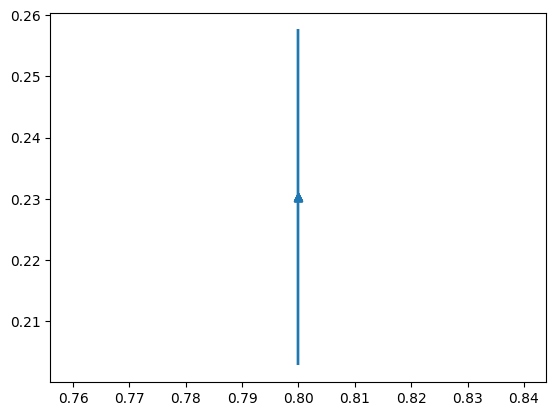

In [23]:
x, y, e = [], [], []

for vel in np.arange(0.1, 1.0, 0.1):
    x.append(float(key[:3]))
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')

0.9 -> 0.0. Mean: 0.15. Std: 0.041
0.9 -> 0.1. Mean: 0.132. Std: 0.022
0.9 -> 0.2. Mean: 0.159. Std: 0.016
0.9 -> 0.3. Mean: 0.168. Std: 0.015
0.9 -> 0.4. Mean: 0.178. Std: 0.012
0.9 -> 0.5. Mean: 0.193. Std: 0.022
0.9 -> 0.6. Mean: 0.205. Std: 0.011
0.9 -> 0.7. Mean: 0.224. Std: 0.013
0.9 -> 0.8. Mean: 0.23. Std: 0.008
0.9 -> 0.9. Mean: 0.262. Std: 0.029


<ErrorbarContainer object of 3 artists>

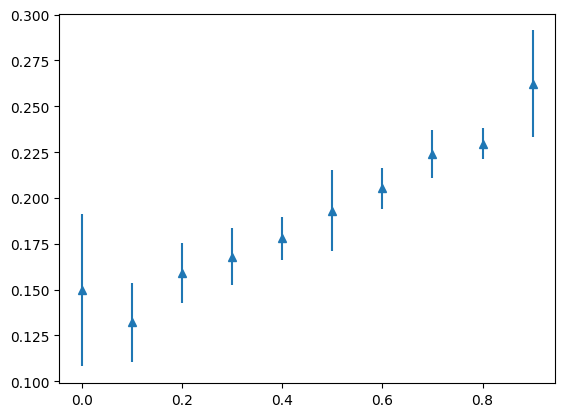

In [75]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.0, 0.1), 2):
    start = 0.9
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')

In [55]:
for x in range(len(e)):
    
    print(f"Accelerating from {0.0} to "
np.round(e, 3)

array([0.011, 0.012, 0.005, 0.008, 0.007, 0.007, 0.014, 0.008, 0.016,
       0.016])

In [54]:
np.round(y, 3)

array([0.009, 0.022, 0.041, 0.058, 0.072, 0.089, 0.097, 0.117, 0.123,
       0.139])